The data we need is in both Quotebank and wikidata. From quotebank we extract quotes, speakers and dates. From Wikidata we extract the political party corresponding to the speakers. Below we will present the exploration of the data that are useful to us. The goal of this notebook is to show our initial treatment of the data: the preprocessing and all the necessary descriptive statistics tasks. 

The first thing we need to do is to merge the two datasets in order to label the quotes with the political party associated. 
MICHAIL explain what you did!
We write the resulting merged data into a file accessible at path QUOTES_2020_PARTY_LABELED_PATH.

MERGING PIPELINE

In [17]:
!pip3 install pandas==1.3.0

In [2]:
from helpers import *
import bz2
import json

In [3]:
#Let's see some lines of the file

path_to_file = fixpath(QUOTES_2020_PARTY_LABELED_PATH) 

flag = 1
with bz2.open(path_to_file, 'rb') as s_file:
      for instance in s_file:   
            if flag < 5:
                instance = json.loads(instance) # loading a sample
                print(instance)
                print('-----------------------------------------')
                flag +=1
            else:
                break

{'quoteID': '2020-01-16-000088', 'quotation': '[ Department of Homeland Security ] was livid and strongly urged to have the agenda pulled.', 'speaker': 'Sue Myrick', 'date': 1579176013000, 'numOccurrences': 1, 'id': 'Q367796', 'party_label': 'R', 'US_congress_bio_ID': 'M001134'}
-----------------------------------------
{'quoteID': '2020-01-26-000499', 'quotation': 'a few of the candidates who will do better in our part of the world', 'speaker': 'Dave Loebsack', 'date': 1580044896000, 'numOccurrences': 11, 'id': 'Q771586', 'party_label': 'D', 'US_congress_bio_ID': 'L000565'}
-----------------------------------------
{'quoteID': '2020-01-26-040663', 'quotation': 'The generational thing is important, quite honestly. I think we have to do everything we can to move this party forward and Pete is the future of the party,', 'speaker': 'Dave Loebsack', 'date': 1580044896000, 'numOccurrences': 11, 'id': 'Q771586', 'party_label': 'D', 'US_congress_bio_ID': 'L000565'}
---------------------------

From the fileld US_congress_bio_ID we can see if the speaker is a senator or is just affiliated to the political party.

# DATA EXPLORATION: STUDY OF VARIOUS DISRIBUTIONS
Let's Visualize and study different data distibution, and check that everything makes sense.

## 1. Let's analyize the distribution of number of words in the quotes.

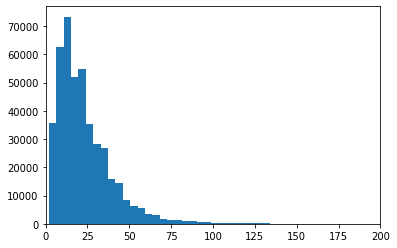

In [58]:
import matplotlib.pyplot as plt
path_to_file = fixpath(QUOTES_2020_PARTY_LABELED_PATH) 
lista = []
with bz2.open(path_to_file, 'rb') as s_file:   
      for instance in s_file:
        instance = json.loads(instance)
        text = instance['quotation']
        lista.append(len(text.split()))

plt.hist(lista, bins = 100)
plt.xlim(0,200)
plt.show()

If we just look at all the data everything looks kind of normal, but let's zoom on the larger values

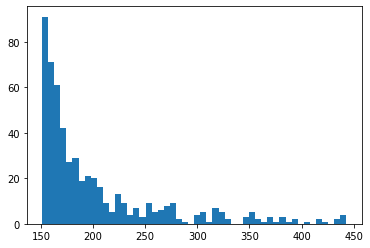

In [5]:
path_to_file = fixpath(QUOTES_2020_PARTY_LABELED_PATH) 
lista = []
with bz2.open(path_to_file, 'rb') as s_file:   
      for instance in s_file:
            instance = json.loads(instance)
            text = instance['quotation']
            if len(text.split()) > 150:
                lista.append(len(text.split()))

plt.hist(lista, bins = 50)
plt.show()

From 300 to 450 the data seems to have a distribution almost uniform but it's true that the number of quotation is low and therfore it could be fine. Lets read some of this long quotes!

In [6]:
lista = []
cnt = 0
with bz2.open(path_to_file, 'rb') as s_file:   
      for instance in s_file:
            instance = json.loads(instance)
            text = instance['quotation']
            lista.append(len(text.split()))
            if len(text.split()) > 400:
                print(text)
                print('-------------------------------------------------------')

where the virus first emerged late last year, and which has suffered the vast majority of infections -- by imposing travel controls and shutting down public events. Italy on Saturday saw its biggest daily increase in coronavirus cases since the outbreak began in the north of the country on Feb. 21. In its daily update, Italy's civil protection agency said the number of people with the coronavirus rose by 1,247 in the last 24 hours, taking the total to 5,883. Another 36 people also died as a result of the virus, taking the total to 233. There was chaos and confusion in the northern Italian city of Padua in the Veneto region as word spread late Saturday evening that the government was planning to announce the quarantine. Packed bars and restaurants quickly emptied out as many people rushed to the train station in Padua. Travellers with suitcases, wearing face masks, gloves and carrying bottles of sanitizing gel shoved their way on to trains. Before Conte signed the quarantine decree, Ste

Most of the quotes looks good, even if some are clearly not quotes (look at the last one), but many contains wird 'â € ','â € ™','â € ' sequences of carachters! 

In [7]:
import bz2
import json
path_to_file = fixpath(QUOTES_2020_PARTY_LABELED_PATH) 
list = []
cnt = 0
with bz2.open(path_to_file, 'rb') as s_file:   
      for instance in s_file:
        instance = json.loads(instance)
        text = instance['quotation']
        if 'â € ' in text or 'â € ™' in text:
            cnt +=1

print(cnt)

74


A quick research on google and we convninced ourselfs that this problem is coming from a UTF-8 encoding bug when creating the datset. (see https://www.i18nqa.com/debug/utf8-debug.html) which occurs either when the dataset is created or which is present on the website from which the quote is extracted. We find strange the high concentration of these bugs within the longer citations in fact within the whole dataset we studied only 74 citations contain these bugs. Let's print the problematic char to be sure that the problem is not the jupyter notebook not supporting this special chars.

In [8]:
print('“')

“


Lastly let's check in one of the original text if the bug is alredy present using the url present in the raw dataset. Since all the urls bring us to a single website we assume that the bug is in there.

In [9]:
path_to_file = QUOTES_2020_PARTY_LABELED_COMPLETE
with bz2.open(path_to_file, 'rb') as s_file:   
      for instance in s_file:
            instance = json.loads(instance)
            text = instance['quotation']
            if 'â € ' in text or 'â € ™' in text:
                print(instance['urls'])

NameError: name 'QUOTES_2020_PARTY_LABELED_COMPLETE' is not defined

Lets analyse the medium lenght of the sentences between republicans and democrats. 


In [59]:
import regex as re
import pandas as pd
import numpy as np
import datetime
path_to_file = QUOTES_2020_PARTY_LABELED_PATH


labeled_df = pd.io.json.read_json(path_to_file, lines=True)

def get_info(x):
    x = x.split(" ")
    return len(x)
labeled_df["length_quote"] = labeled_df["quotation"].apply(lambda x: get_info(x))

mean_quote_lenght_D = labeled_df[labeled_df["party_label"] == "D"]["length_quote"].mean()
mean_quote_lenght_R = labeled_df[labeled_df["party_label"] == "R"]["length_quote"].mean()
print(mean_quote_lenght_D)
print(mean_quote_lenght_R)

23.194002792541212
23.527082451934376


Lets see if the mean difference is significant.

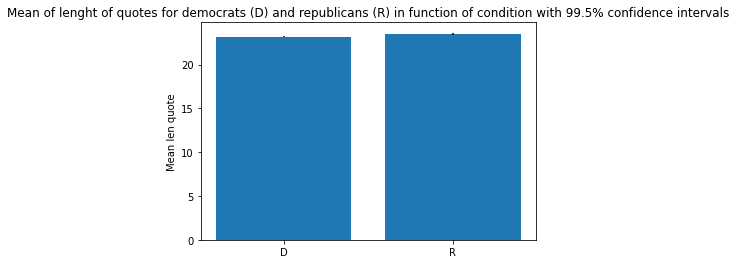

In [65]:
def bootstrap_CI(data, nbr_draws):
    means = np.zeros(nbr_draws)
    data = np.array(data)

    for n in range(nbr_draws):
        indices = np.random.randint(0, len(data), len(data))
        data_tmp = data[indices] 
        means[n] = np.nanmean(data_tmp)
    return [np.nanpercentile(means, 0.05),np.nanpercentile(means, 99.5)]

mean_signBottom ,meanSignTop = labeled_df.groupby(by="party_label").mean()["length_quote"]

party_label = labeled_df.groupby("party_label")["length_quote"].apply(lambda x : x.tolist())

[lower_signBottom,upper_signBottom] = bootstrap_CI(party_label.iloc[0],1000)
[lower_signTop,upper_signTop] = bootstrap_CI(party_label.iloc[1],1000)

plt.bar([str(party_label.index[0]),str(party_label.index[1])],[mean_signBottom,meanSignTop],yerr = [[mean_signBottom-lower_signBottom,meanSignTop-lower_signTop],[upper_signBottom-mean_signBottom,upper_signTop-meanSignTop]])
plt.ylabel("Mean len quote")
plt.title("Mean of lenght of quotes for democrats (D) and republicans (R) in function of condition with 99.5% confidence intervals");

Lets zoom in by restricting the y-axes limit

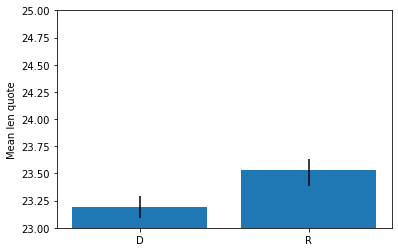

In [67]:
plt.bar([str(party_label.index[0]),str(party_label.index[1])],[mean_signBottom,meanSignTop],yerr = [[mean_signBottom-lower_signBottom,meanSignTop-lower_signTop],[upper_signBottom-mean_signBottom,upper_signTop-meanSignTop]])
plt.ylabel("Mean len quote")
plt.ylim(23,25);

As we can notice the two lines are not overlapping thus. even slightly, the mean difference is significant. We can thus deduce that republicans have tendency to have slightly larger sentence than democrats.

## 2. Let's analyize the distribution of number of quotes in time.

In [ ]:
formatted_df = labeled_df.copy()
formatted_df["date"] = pd.to_datetime(formatted_df['date'], format='%Y-%m-%d %H:%M:%S')

#plot the data
bins = 100
hist = plt.hist(formatted_df["date"].dt.date,bins)
plt.xlim([datetime.date(2020, 3, 15), datetime.date(2020, 4, 1)])
plt.xticks([datetime.date(2020, i, 1) for i in range(1,5)])
plt.xlabel("Date")
plt.ylabel("Number of quotes")
plt.title("Number of quotes per date")
plt.show()

What are those drops? Lets check the first 2 months by printing the dates

In [ ]:
#we range over two months over each day and we print the dates which have less than 3500 quotes (a bit less than the average)
for j in range(1,2):
    for i in range(1,30):
        if len(formatted_df[formatted_df.values == datetime.date(2020,j,i)]) < 3500:
            print('2020-%d-%d' % (j,i))

As we can see from these values, by checking in the calendar, these drops correspond to the weekends / holidays day, in which we assume that no quotes where inserted in the newspaper the plot.

Now lets analysis the spikes instead. We firsty get the top 10 most frequent dates of quotes, and later show them on the graph.

In [ ]:
# get top 10 most frequent dates of quotes
n = 10
days_with_most_quotes = formatted_df['date'].value_counts()[:n].index.tolist()
days_with_most_quotes

By checking the dates with the calendar, we found that these dates are related to presidential events. Lets see some examples:
- 2020-01-15 -> the Pentagon construction was completed.
- 2020-01-30 -> President Trump signed the U.S.-Mexico-Canada (USMCA) trade pact.
- 2020-02-05: "Trump impeachment vote live updates: Sharply divided Senate acquits Trump on both articles"
- 2020-02-07 -> "United States President Donald Trump is acquitted by the United States Senate in his first impeachment trial."

Lets display them on the graph.

In [ ]:
events = {datetime.date(2020, 2, 5):'T. Imp.',
          datetime.date(2020, 1, 15): 'Pentagon',
          datetime.date(2020, 1, 30):'U-M-C'}
events_keys = []
events_values = []
for i in events.keys():
    events_keys.append(i)
for j in events.values():
    events_values.append(j)

In [ ]:
bins = 100
hist = plt.hist(formatted_df["date"].dt.date,bins)
plt.xlim([datetime.date(2020, 1, 1), datetime.date(2020,4, 1)])
plt.xticks([events_keys[i] for i in range(0,len(events_keys))],[events_values[i] for i in range(0,len(events_values))],fontsize=7)
plt.show()

#### TO REMOVE SINCE WE DONT CARE ABOUT SENATORS - NON SENATORS

Lets now check if there is any different between the senators amount of quotes and the non-senator amount of quotes during these days

In [ ]:
#senators dataframe
senators_df = formatted_df[formatted_df["US_congress_bio_ID"] != None]
senators_df = formatted_df[~formatted_df["US_congress_bio_ID"].isnull()]

#non-senators dataframe
non_senators_df = formatted_df[formatted_df["US_congress_bio_ID"] == None]
non_senators_df = formatted_df[formatted_df["US_congress_bio_ID"].isnull()]

#print the lenght of datasets
print('Senators dataframe length:',len(senators_df))
print('Non-Senators dataframe length:',len(non_senators_df))

In [ ]:
fig, (ax1,ax2) = plt.subplots(1, 2,sharex='all', sharey='all',figsize=(15,5))
ax1.hist(senators_df["date"].dt.date,bins)
ax1.set_title('Senators amount of quotes per date')
ax1.set_ylabel('Number of quotes')
ax1.set_xlabel('Date')
ax1.set_xticks([])

ax2.hist(non_senators_df["date"].dt.date,bins)
ax2.set_title('Non-Senators amount of quotes per date')
ax2.set_xticks([])

ax2.set_xlabel('Date');

MONO ANALYSIS

## 3.Let's analyize the words used in the quotes

MICHAEL ANALYSIS FROM ?

# DUPLICATES ANALISYS
Let's just analize if there are duplicates in the quotations. If we just take quotations as they are we cannot see any duplicates but with a bit of processing we can easily spot some...

In [ ]:
import texthero as hero
import pandas as pd

path_to_file = fixpath(QUOTES_2020_PARTY_LABELED_PATH) 

from texthero import preprocessing

#Read the dataset
testdf = pd.io.json.read_json(path_to_file, lines=True)
#Put every letter to lowercase, remove whitespaces and punctuation
custom_pipeline = [preprocessing.lowercase,
                   preprocessing.remove_whitespace,
                   preprocessing.remove_punctuation]
testdf['clean_quotes'] = hero.clean(testdf['quotation'], custom_pipeline)

#Check for duplicate in the original and in the cleaned version
print(testdf['quotation'].duplicated().sum())
print(testdf['clean_quotes'].duplicated().sum())
#print some duplicate sentences
testdf[testdf['clean_quotes'].duplicated()]['quotation'].head(5)

In [ ]:
#let's visualize the two quotes: this are indeed duplicates
testdf[testdf['clean_quotes']==testdf['clean_quotes'].iloc[10099]]

This means that we need to do some cleaning. Of course this analisys is not complete we need to find a more systematic way to spot duplicates. To spot duplicates we use Jaccard similarity between pairs of quotes of the same speaker. 

NICKY STUFF FOR DROPPING DUPLICATES

# HOW HARD IS OUR TASK?
To have a sense of how hard the task will be let's try to analise the data distribution in a lower dimension. To do that we need to transform the text into a numeric format, using tf-idf model,  then apply PCA to the result. Before representing quotes as vectors we preprocess the data. As we can  see the data does not look to be separable by class in the PCA plot. 

In [ ]:
import texthero as hero
import pandas as pd

labeled_df = pd.io.json.read_json(path_to_file, lines=True)
labeled_df_dem= labeled_df[labeled_df['party_label']=='D'].head(500)
labeled_df_rep= labeled_df[labeled_df['party_label']=='R'].head(500)

pca_df = pd.concat([labeled_df_dem, labeled_df_rep])
pca_df['pca'] = (
            pca_df['quotation']
            .pipe(hero.clean)
            .pipe(hero.tfidf)
            .pipe(hero.pca)
   )
hero.scatterplot(pca_df, col='pca', color='party_label', title="PCA party quotations",hover_data = ['quotation','speaker'])

We will now train a small classification model and see if our main goal is feasible.

In [ ]:
#NEED BALANCED DATA!!
labeled_df = pd.io.json.read_json(path_to_file, lines=True)

#labeled_df_senators = labeled_df[labeled_df['US_congress_bio_ID'] != 'None']
labeled_df_dem= labeled_df[labeled_df['party_label']=='D'].head(20000)
labeled_df_rep= labeled_df[labeled_df['party_label']=='R'].head(20000)
labeled_df_senators = pd.concat([labeled_df_dem, labeled_df_rep])
labeled_df_senators['vect_quotes'] = labeled_df_senators['quotation'].pipe(hero.clean).pipe(hero.tfidf)

X = labeled_df_senators[labeled_df['US_congress_bio_ID'] != 'None']['vect_quotes'].tolist()
y = labeled_df_senators[labeled_df['US_congress_bio_ID'] != 'None']['party_label'].tolist()

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

print('xshape: ',len(X),'yshape: ',len(y))
clf = RandomForestClassifier(n_estimators=10)

scores = cross_val_score(clf, X,y, cv=5)
scores.mean()

In [ ]:
labeled_df_senators['party_label'].value_counts()

In [ ]:
labeled_df.groupby('state')['quotation'].apply(lambda x: hero.top_words(x)[:30])